# Three-phase line analyzer for non-sinusoidal systems

In [88]:
import numpy as np
from daqthreephi import DataGen
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, irfft

In [259]:
def rmsValue(array):
    """
    This function gives the RMS value of an array (function or signal)
    :param array: an np array
    :return: the RMS value
    """
    quad_array = array ** 2
    rms = np.sqrt(np.mean(quad_array))

    return rms


def activePower(voltage, current):
    """
    This function calculate the active Power of a given voltage and current
    :param voltage: numpy voltages array
    :param current: numpy currents array
    :return: active power of the given arrays
    """
    instantPower = voltage * current
    actPower = np.mean(instantPower)

    return actPower


def reactivePower(voltage, current):
    """
    Calculate the reactive power of a line using the
    Fryze definition
    :param voltage: array with the voltages
    :param current: array with the currents
    :return: Fryze reactive Power
    """

    P = activePower(voltage, current)
    Irms = rmsValue(current)
    Vrms = rmsValue(voltage)
    S = Irms * Vrms
    Qf = np.sqrt(S ** 2 - P ** 2)

    return Qf


def boudReactP(v_fft, i_fft, n):
    """
    This function calculates the Boudeanu Reactive Power Q_B
    :param v_fft: voltage's fft
    :param i_fft: current's fft
    :param n: samples number
    :return: Budeanu reactive power
    """
    magVcoefs = 2 / n * np.abs(v_fft[0:n // 2])
    magIcoefs = 2 / n * np.abs(i_fft[0:n // 2])

    ang_v = getCoeffs(np.angle(v_fft[0:n // 2]))
    ang_i = getCoeffs(np.angle(i_fft[0:n // 2]))

    Vkrms = getCoeffs(magVcoefs / np.sqrt(2))
    Ikrms = getCoeffs(magIcoefs / np.sqrt(2))

    Qb = np.sum(Vkrms * Ikrms * np.sin(ang_v - ang_i))

    return Qb


def getCoeffs(ft):
    """
    This function gets just the important harmonics from the fft
    :param ft: numpy array with all the coefficients of fft
    :return: array with the values of each harmonic
    """
    steps = np.arange(0, len(ft), 5)
    coefs = np.zeros(len(steps))
    n = 0
    for i in steps:
        coefs[n] = ft[i]
        n += 1

    return coefs


def signalThd(coeffs):
    """
    This function calculates the Total Harmonic Distortion for a given
    Fourier coefficients
    :param coeffs: np array with coefficients from the fft
    :return: thd in percent [%]
    """
    quadCoeffs = (coeffs[2:]) ** 2
    dist = np.sum(quadCoeffs)
    thd = (np.sqrt(dist) / coeffs[1]) * 100

    return thd


def compareTHD(thd_value):
    """
    This function compare the THD voltage value and determine
    if it meets the standard
    :param thd_value: thd voltage value to evaluate
    :return: None
    """
    if thd_value > 5:
        print("WARNING!: THDv value is higher than 5%.")


def spDens(norm_coefs):
    """

    :param norm_coefs:
    :return:
    """
    norm_coefs = getCoeffs(norm_coefs)
    p_coeffs = norm_coefs ** 2
    dens = np.cumsum(p_coeffs)

    return dens


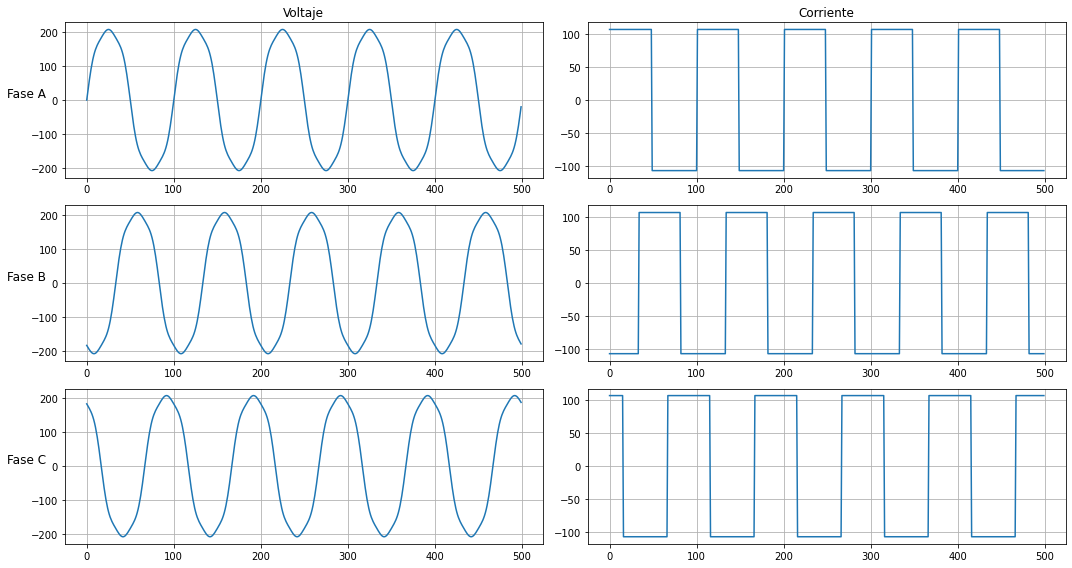

In [90]:
system = DataGen(63)
system.plot()

In [91]:
voltages, currents = system.get_data()

# Obtain every voltage and current value
v1 = voltages[0]
v2 = voltages[1]
v3 = voltages[2]

i1 = currents[0]
i2 = currents[1]
i3 = currents[2]

# Calculate the RMS value of the tensions and currents
v1_rms = rmsValue(v1)
v2_rms = rmsValue(v2)
v3_rms = rmsValue(v3)

i1_rms = rmsValue(i1)
i2_rms = rmsValue(i2)
i3_rms = rmsValue(i3)

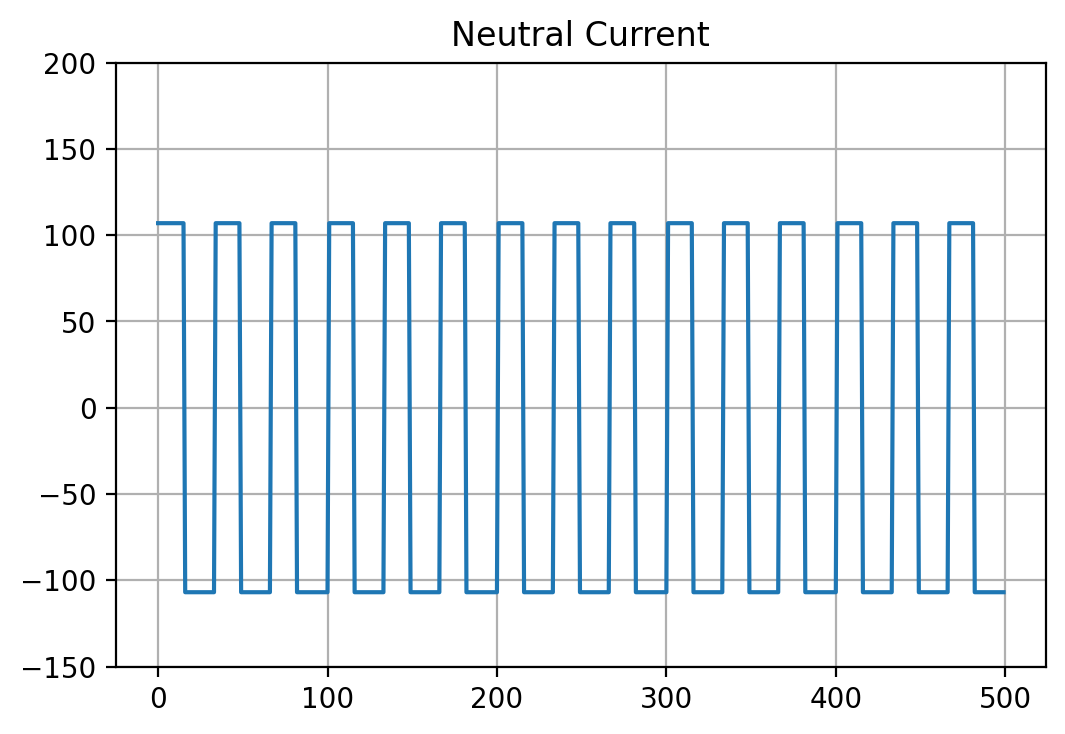

In [92]:
# Calculation and graph of the current in the neutral
i_n = i1 + i2 + i3

ticks = np.arange(-150, 201, 50)

plt.figure(dpi=200)
plt.plot(i_n)
plt.title("Neutral Current")
plt.yticks(ticks)
plt.grid()
plt.show()

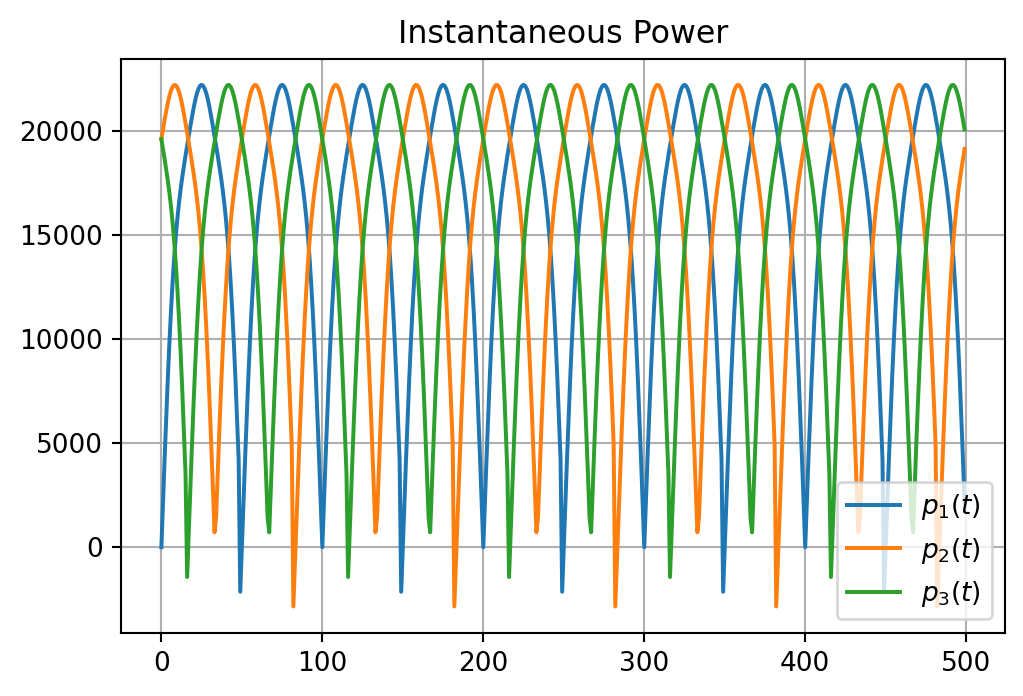

In [103]:
# Calculate the power of the system

# Instantaneous power
p1ins = v1 * i1
p2ins = v2 * i2
p3ins = v3 * i3

plt.figure(dpi=190)
plt.plot(p1ins, label="$p_1(t)$")
plt.plot(p2ins, label="$p_2(t)$")
plt.plot(p3ins, label="$p_3(t)$")
plt.legend()
plt.title("Instantaneous Power")
plt.grid()
plt.show()

# Active power for each phase
p1 = activePower(v1, i1)
p2 = activePower(v2, i2)
p3 = activePower(v3, i3)

pt = p1 + p2 + p3

# Apparent power for each phase80.23311157182988 80.23311157183106 80.23311157183106
s1 = v1_rms * i1_rms
s2 = v2_rms * i2_rms
s3 = v3_rms * i3_rms

# Fryze reactive power for each phase
q1 = reactivePower(v1, i1)
q2 = reactivePower(v2, i2)
q3 = reactivePower(v3, i3)

qt = q1 + q2 + q3

st = np.sqrt(pt ** 2 + qt ** 2)

22°


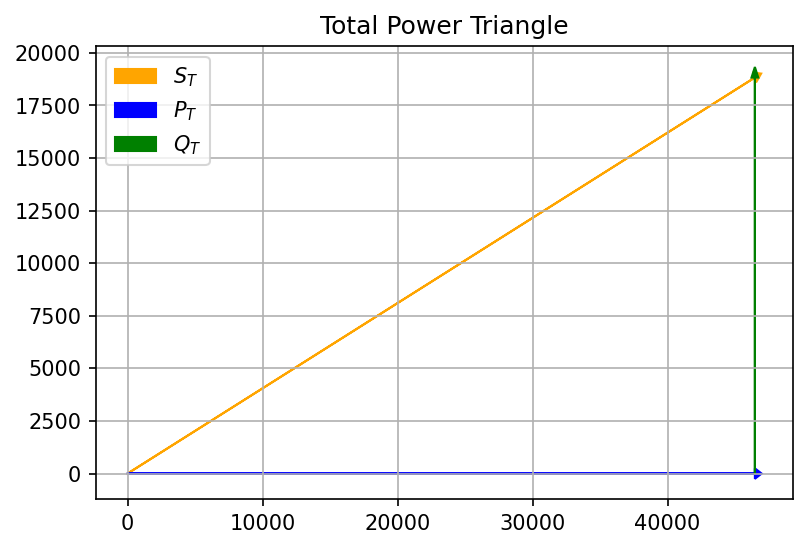

In [132]:
# Potencia fasorial del sistema
sfas = pt + qt * 1j
s_vector = np.array(pt, qt)
s_total = np.abs(sfas)

labels = ["P", "Qf"]
theta = np.angle(sfas, deg=True)
print("{}°".format(round(theta)))

plt.figure(dpi=150)
ax = plt.axes()
ax.arrow(0, 0, pt, qt, head_width=500, head_length=500, label='$S_T$', color='orange')
ax.arrow(0, 0, pt, 0, head_width=500, head_length=500, label='$P_T$', color='blue')
ax.arrow(pt, 0, 0, qt, head_width=500, head_length=500, label='$Q_T$', color='green')
plt.legend()
plt.title('Total Power Triangle')
plt.grid()
plt.show()

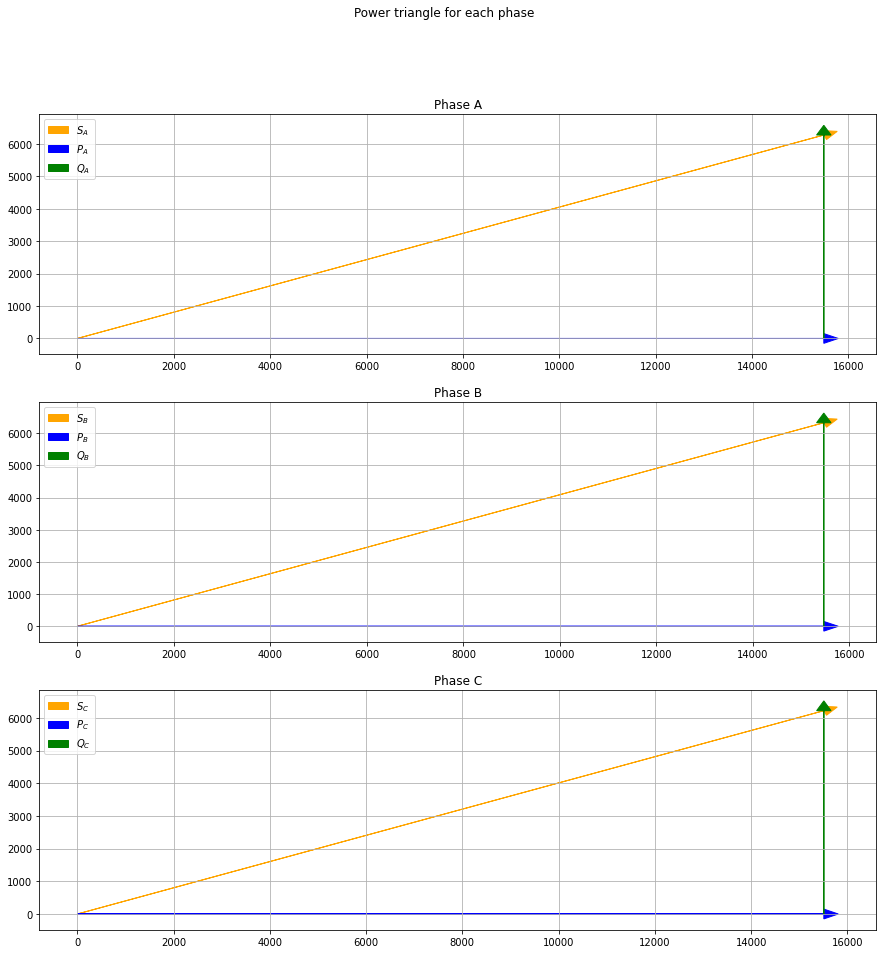

In [144]:
fig, ax = plt.subplots(3, figsize=(15, 15))
fig.suptitle('Power triangle for each phase')
ax[0].arrow(0, 0, p1, q1, head_width=300, head_length=300, label='$S_A$', color='orange')
ax[0].arrow(0, 0, p1, 0, head_width=300, head_length=300, label='$P_A$', color='blue')
ax[0].arrow(p1, 0, 0, q1, head_width=300, head_length=300, label='$Q_A$', color='green')
ax[0].set_title('Phase A')
ax[0].legend()
ax[0].grid()

ax[1].arrow(0, 0, p2, q2, head_width=300, head_length=300, label='$S_B$', color='orange')
ax[1].arrow(0, 0, p2, 0, head_width=300, head_length=300, label='$P_B$', color='blue')
ax[1].arrow(p2, 0, 0, q2, head_width=300, head_length=300, label='$Q_B$', color='green')
ax[1].set_title('Phase B')
ax[1].legend()
ax[1].grid()

ax[2].arrow(0, 0, p3, q3, head_width=300, head_length=300, label='$S_C$', color='orange')
ax[2].arrow(0, 0, p3, 0, head_width=300, head_length=300, label='$P_C$', color='blue')
ax[2].arrow(p3, 0, 0, q3, head_width=300, head_length=300, label='$Q_C$', color='green')
ax[2].set_title('Phase C')
ax[2].legend()
ax[2].grid()

In [95]:
# Fast Fourier Transform
Fs = 6000  # Sample Frequency [Hz]
N = len(i1)  # Amount of data

xf = fftfreq(N, 1 / Fs)[: N // 2]

# Fourier's coefficients for each voltage
v1f = fft(v1)
v1f_norm = 2 / N * np.abs(v1f[0:N // 2])

v2f = fft(v2)
v2f_norm = 2 / N * np.abs(v2f[0:N // 2])

v3f = fft(v3)
v3f_norm = 2 / N * np.abs(v3f[0:N // 2])

# Fourier's coefficients for each current
i1f = fft(i1)
i1f_norm = 2 / N * np.abs(i1f[0:N // 2])

i2f = fft(i2)
i2f_norm = 2 / N * np.abs(i2f[0:N // 2])

i3f = fft(i3)
i3f_norm = 2 / N * np.abs(i3f[0:N // 2])

In [101]:
# Reactive Budeanu Power
qb1 = boudReactP(v1f, i1f, N)
qb2 = boudReactP(v2f, i2f, N)
qb3 = boudReactP(v3f, i3f, N)

qbt = qb1 + qb2 + qb3

# Distortion Power
d1 = np.sqrt(s1 ** 2 - p1 ** 2 - qb1 ** 2)
d2 = np.sqrt(s2 ** 2 - p2 ** 2 - qb2 ** 2)
d3 = np.sqrt(s3 ** 2 - p3 ** 2 - qb3 ** 2)

dt = np.sqrt(st ** 2 - pt ** 2 - qbt ** 2)

print('D')
print(d1, d2, d3, dt)

D
6248.464415634164 6265.54612753306 6181.370016931371 18697.79875704684


[ 1.1000000e+02 -2.0000000e+01  4.0000000e+00 -8.5297235e-15] [ 1.90525589e+02 -1.18870225e-13 -6.92820323e+00 -5.33011783e-15]


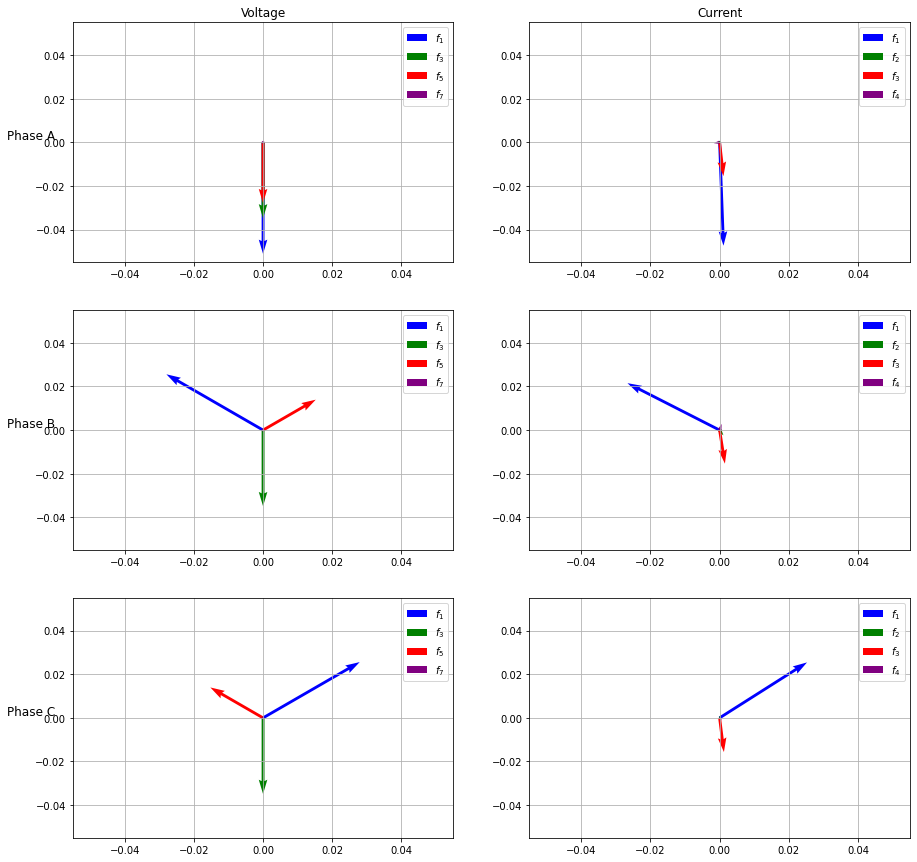

In [258]:
# Phasor diagrams for each phase
col_labels = ["Voltage", "Current"]
row_labels = ["Phase A", "Phase B", "Phase C"]
colors = ["blue", "green", "red", "purple"]
labelv = ['$f_1$', '$f_3$', '$f_5$', '$f_7$']
labeli = ['$f_1$', '$f_2$', '$f_3$', '$f_4$']

x_pos = 0
y_pos = 0

v1_c = (2 / N) * np.array([v1f[5], v1f[15], v1f[25], v1f[35]])
v1_cR = v1_c.real
v1_cI = v1_c.imag
v2_c = (2 / N) * np.array([v2f[5], v2f[15], v2f[25], v2f[30]])
v2_cR = v2_c.real
v2_cI = v2_c.imag
v3_c = (2 / N) * np.array([v3f[5], v3f[15], v3f[25], v3f[35]])
v3_cR = v3_c.real
v3_cI = v3_c.imag

i1_c = (2 / N) * np.array([i1f[5], v1f[10], i1f[15], i1f[20]])
i1_cR = i1_c.real
i1_cI = i1_c.imag
i2_c = (2 / N) * np.array([i2f[5], i2f[10], i2f[15], i2f[20]])
i2_cR = i2_c.real
i2_cI = i2_c.imag
i3_c = (2 / N) * np.array([i3f[5], i3f[10], i3f[15], i3f[20]])
i3_cR = i3_c.real
i3_cI = i3_c.imag

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Voltages
axs[0, 0].quiver(x_pos, y_pos, v1_cR[0], v1_cI[0], scale=750, color=colors[0], label=labelv[0])
axs[0, 0].quiver(x_pos, y_pos, v1_cR[1], v1_cI[1], scale=100, color=colors[1], label=labelv[1])
axs[0, 0].quiver(x_pos, y_pos, v1_cR[2], v1_cI[2], scale=50, color=colors[2], label=labelv[2])
axs[0, 0].quiver(x_pos, y_pos, v1_cR[3], v1_cI[3], scale=1, color=colors[3], label=labelv[3])
axs[0, 0].legend()
axs[0, 0].grid()

axs[1, 0].quiver(x_pos, y_pos, v2_cR[0], v2_cI[0], scale=750, color=colors[0], label=labelv[0])
axs[1, 0].quiver(x_pos, y_pos, v2_cR[1], v2_cI[1], scale=100, color=colors[1], label=labelv[1])
axs[1, 0].quiver(x_pos, y_pos, v2_cR[2], v2_cI[2], scale=50, color=colors[2], label=labelv[2])
axs[1, 0].quiver(x_pos, y_pos, v2_cR[3], v2_cI[3], scale=1, color=colors[3], label=labelv[3])
axs[1, 0].legend()
axs[1, 0].grid()

axs[2, 0].quiver(x_pos, y_pos, v3_cR[0], v3_cI[0], scale=750, color=colors[0], label=labelv[0])
axs[2, 0].quiver(x_pos, y_pos, v3_cR[1], v3_cI[1], scale=100, color=colors[1], label=labelv[1])
axs[2, 0].quiver(x_pos, y_pos, v3_cR[2], v3_cI[2], scale=50, color=colors[2], label=labelv[2])
axs[2, 0].quiver(x_pos, y_pos, v3_cR[3], v3_cI[3], scale=1, color=colors[3], label=labelv[3])
axs[2, 0].legend()
axs[2, 0].grid()

# Currents
axs[0, 1].quiver(x_pos, y_pos, i1_cR[0], i1_cI[0], scale=500, color=colors[0], label=labeli[0])
axs[0, 1].quiver(x_pos, y_pos, i1_cR[1], i1_cI[1], scale=500, color=colors[1], label=labeli[1])
axs[0, 1].quiver(x_pos, y_pos, i1_cR[2], i1_cI[2], scale=500, color=colors[2], label=labeli[2])
axs[0, 1].quiver(x_pos, y_pos, i1_cR[3], i1_cI[3], scale=500, color=colors[3], label=labeli[3])
axs[0, 1].legend()
axs[0, 1].grid()

axs[1, 1].quiver(x_pos, y_pos, i2_cR[0], i2_cI[0], scale=500, color=colors[0], label=labeli[0])
axs[1, 1].quiver(x_pos, y_pos, i2_cR[1], i2_cI[1], scale=500, color=colors[1], label=labeli[1])
axs[1, 1].quiver(x_pos, y_pos, i2_cR[2], i2_cI[2], scale=500, color=colors[2], label=labeli[2])
axs[1, 1].quiver(x_pos, y_pos, i2_cR[3], i2_cI[3], scale=500, color=colors[3], label=labeli[3])
axs[1, 1].legend()
axs[1, 1].grid()

axs[2, 1].quiver(x_pos, y_pos, i3_cR[0], i3_cI[0], scale=500, color=colors[0], label=labeli[0])
axs[2, 1].quiver(x_pos, y_pos, i3_cR[1], i3_cI[1], scale=500, color=colors[1], label=labeli[1])
axs[2, 1].quiver(x_pos, y_pos, i3_cR[2], i3_cI[2], scale=500, color=colors[2], label=labeli[2])
axs[2, 1].quiver(x_pos, y_pos, i3_cR[3], i3_cI[3], scale=500, color=colors[3], label=labeli[3])
axs[2, 1].legend()
axs[2, 1].grid()

for ax, col in zip(axs[0], col_labels):
    ax.set_title(col)

for ax, row in zip(axs[:, 0], row_labels):
    ax.set_ylabel(row, rotation=0, size='large')

print(v3_cI, v3_cR)

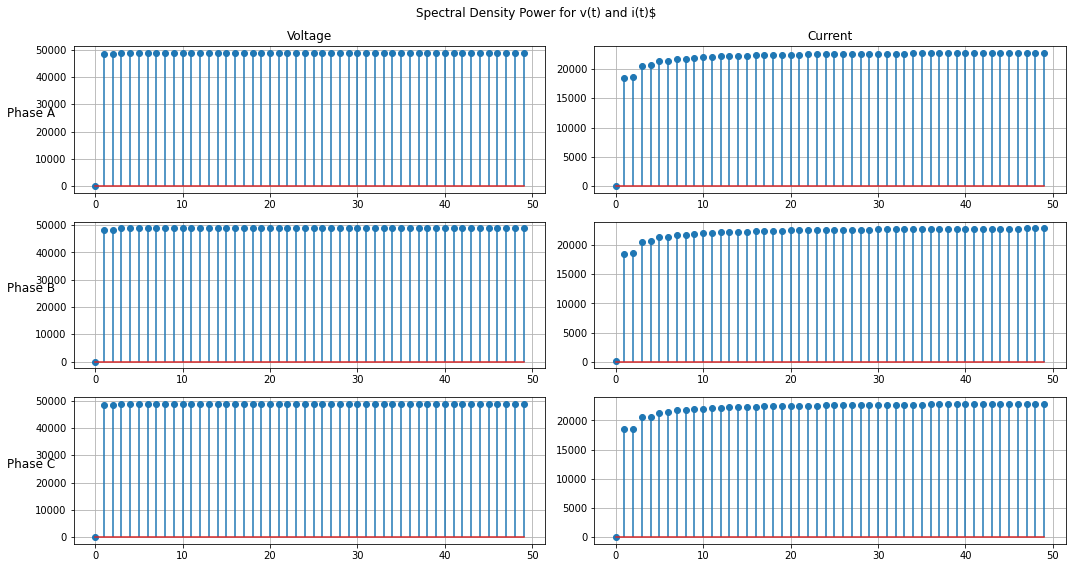

In [98]:
# Spectral density power for each phase
col_labels = ["Voltage", "Current"]
row_labels = ["Phase A", "Phase B", "Phase C"]

# Tension
d_v1 = spDens(v1f_norm)
d_v2 = spDens(v2f_norm)
d_v3 = spDens(v3f_norm)

# Currents
d_i1 = spDens(i1f_norm)
d_i2 = spDens(i2f_norm)
d_i3 = spDens(i3f_norm)

fig, axs = plt.subplots(3, 2, figsize=(15, 8))

fig.suptitle("Spectral Density Power for v(t) and i(t)$", size='large')

axs[0, 0].stem(d_v1)
axs[0, 0].grid()
axs[1, 0].stem(d_v2)
axs[1, 0].grid()
axs[2, 0].stem(d_v3)
axs[2, 0].grid()

axs[0, 1].stem(d_i1)
axs[0, 1].grid()
axs[1, 1].stem(d_i2)
axs[1, 1].grid()
axs[2, 1].stem(d_i3)
axs[2, 1].grid()

for ax, col in zip(axs[0], col_labels):
    ax.set_title(col)

for ax, row in zip(axs[:, 0], row_labels):
    ax.set_ylabel(row, rotation=0, size='large')

fig.tight_layout()
plt.show()

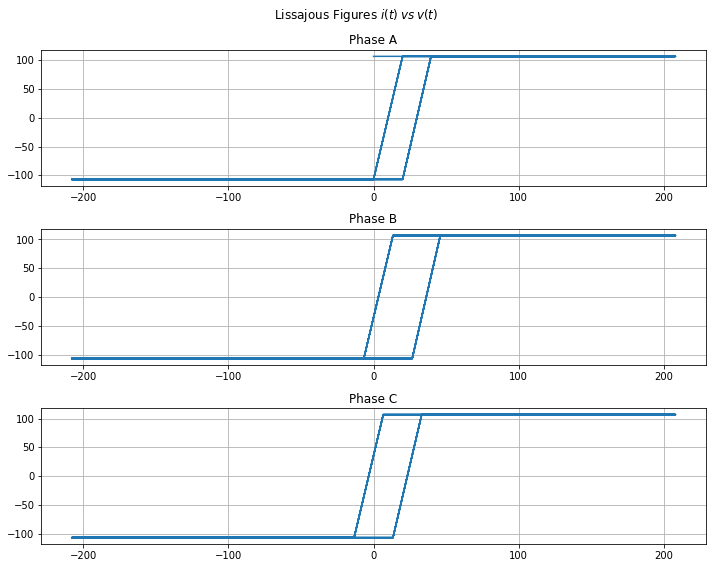

In [99]:
# Lissajous Figures

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 8))
fig.suptitle("Lissajous Figures $i(t)\:vs\:v(t)$", size='large')
ax1.plot(v1, i1)
ax1.set_title("Phase A")
ax1.grid()
ax2.plot(v2, i2)
ax2.set_title("Phase B")
ax2.grid()
ax3.plot(v3, i3)
ax3.set_title("Phase C")
ax3.grid()

fig.tight_layout()

plt.show()


In [260]:
# Calculus of THD for voltages and currents
# THDv
thdv1 = signalThd(getCoeffs(v1f_norm))
thdv2 = signalThd(getCoeffs(v2f_norm))
thdv3 = signalThd(getCoeffs(v3f_norm))

compareTHD(thdv1)
compareTHD(thdv2)
compareTHD(thdv3)

# THDi
thdi1 = signalThd(getCoeffs(i1f_norm))
thdi2 = signalThd(getCoeffs(i2f_norm))
thdi3 = signalThd(getCoeffs(i3f_norm))

print(thdi1, thdi2, thdi3)

WARNING!: THDv value is higher than 5%.
WARNING!: THDv value is higher than 5%.
WARNING!: THDv value is higher than 5%.
47.75911656543122 48.59993266714515 48.32443859859412
